Author: Akash Kharita </br>
email: ak287@uw.edu


## Objective

- This notebook tests the performance of physical features for the purpose of classification of PNSN dataset. 
- before running the cells in this notebook we have to download the extracted features. 

[Downloading the features](#Downloading-the-features)

- Based on the window size and filtering, physical features were extracted from six differently processed waveforms. These feature sets are named P_before_after_F_lowpass_highpass_sampling_rate. e.g., P_10_30_F_1_10_50 (this means the features were extracted from the waveforms that started 10s before and 30s after, bandpass filtered between 1 and 10 Hz and resampled to 50 Hz). We have six such feature sets for three different window lengths (40s, P-10,+30), (110s, P-10,+100), and (150s, P-50, P+100) and two different filters (0.5-15) and (1-10). 


[Loading physical features](#Loading-physical-features)



[Preprocessing the input features](#Preprocessing-the-input-features)



In [1]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
sys.path.append('../src')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import resample_array
from utils import plot_confusion_matrix
from utils import plot_classification_report
from utils import interquartile


import pickle
from zenodo_get import zenodo_get

from pathlib import Path

## Downloading the features

In [2]:
## specify a filename 
filename = 'P_10_30_F_05_15_50'

In [3]:
if filename == 'P_10_30_F_1_15_50':
    doi = '10.5281/zenodo.12747189'
    
elif filename == 'P_10_30_F_1_10_50':
    doi = '10.5281/zenodo.13294736'
    
elif filename == 'P_10_30_F_05_15_50':
    doi = '10.5281/zenodo.13294778'
    
    

    
elif filename == 'P_10_100_F_1_10_50':
    doi = '10.5281/zenodo.12747222'
    
elif filename == 'P_10_100_F_05_15_50':
    doi = '10.5281/zenodo.13294804'
    
    
elif filename == 'P_50_100_F_1_10_50':
    doi = '10.5281/zenodo.12747234'

elif filename == 'P_50_100_F_05_15_50':
    doi = '10.5281/zenodo.13294827'
    
## This is going to download all the feature files in current directory. Make sure we delete them after storing
files = zenodo_get([doi])

Title: Physical and Tsfel Features for (P_10_30_F_05_15_50)
Keywords: 
Publication date: 2024-08-11
DOI: 10.5281/zenodo.13294778
Total size: 1614.9 MB

Link: https://zenodo.org/record/13294778/files/physical_features_earthquake_P_10_30_F_05_15_50_part_4.csv   size: 12.3 MB

Checksum is correct. (c8c72b69e277ad76fcaa043ffac5b9d7)

Link: https://zenodo.org/record/13294778/files/tsfel_features_earthquake_P_10_30_F_05_15_50_part_2.csv   size: 290.1 MB

Checksum is correct. (6db1be651085d6bc91c1e1de7ba1d3ed)

Link: https://zenodo.org/record/13294778/files/physical_features_earthquake_P_10_30_F_05_15_50_part_2.csv   size: 33.2 MB

Checksum is correct. (b2c980a200becb524b14be2f5042ddb8)

Link: https://zenodo.org/record/13294778/files/physical_features_earthquake_P_10_30_F_05_15_50_part_1.csv   size: 34.5 MB

Checksum is correct. (a52552c927d2dd87fce085da56a2cbda)

Link: https://zenodo.org/record/13294778/files/physical_features_explosion_P_10_30_F_05_15_50_part_1.csv   size: 10.6 MB

Checksum

## Loading physical features

In [4]:
# Define file paths
base_path = Path(".")  # Modify if needed

# Load physical features for surface events, thunder, and sonic booms
features_exotic_physical = pd.read_csv(base_path / f'physical_features_surface event_{filename}_part_1.csv')

# Group data by source type for better scalability
grouped_features = {source: df for source, df in features_exotic_physical.groupby('source')}

# Extract specific categories
features_surface_physical = grouped_features.get('surface event', pd.DataFrame())
features_sonic_physical = grouped_features.get('sonic', pd.DataFrame())
features_thunder_physical = grouped_features.get('thunder', pd.DataFrame())

# Load other event features
features_noise_physical = pd.read_csv(base_path / f'physical_features_noise_{filename}_part_1.csv')
features_explosion_physical = pd.read_csv(base_path / f'physical_features_explosion_{filename}_part_1.csv')

# Load and concatenate earthquake features efficiently
earthquake_files = [f'physical_features_earthquake_{filename}_part_{i}.csv' for i in range(1, 5)]
features_earthquake_physical = pd.concat([pd.read_csv(base_path / file) for file in earthquake_files], ignore_index=True)


## Merging the metadata information with the catalogs

In [5]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = features_explosion_physical['serial_no'].values
ind_eq = features_earthquake_physical['serial_no'].values
ind_no = features_noise_physical['serial_no'].values
ind_su = features_surface_physical['serial_no'].values




su_df = cat_su.iloc[ind_su]
su_df.reset_index(drop = True, inplace = True)
su_df['serial_no'] = ind_su
features_surface_physical['event_id'] = su_df['event_id']
features_surface_physical['new_event_id'] = su_df['event_id']+'_'+su_df['station_network_code']+'.'+su_df['station_code']
features_surface_physical['trace_start_time'] = su_df['trace_start_time']


no_df = cat_no.iloc[ind_no]
no_df.reset_index(drop = True, inplace = True)
no_df['serial_no'] = ind_no
features_noise_physical['event_id'] = no_df['trace_start_time']+'_noise'
features_noise_physical['new_event_id'] = no_df['trace_start_time']+'_noise_'+no_df['station_network_code']+'.'+no_df['station_code']
features_noise_physical['trace_start_time'] = no_df['trace_start_time']



/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [6]:
complete_cat_su = pd.merge(features_surface_physical, su_df, on = 'serial_no')
complete_cat_su.to_csv(f'../data/complete_surface_event_catalog_{filename}.csv')

In [7]:
complete_cat_su

,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,Gamma,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,E_20_50,Kurto_20_50,serial_no,source,event_id_x,new_event_id,trace_start_time_x,event_id_y,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time_y,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
0,40.0,4.375038,6.200192,1.357311,8.583693,0.690229,-0.375513,1.015042,139,-6.642068,7.119097,-0.932993,0.477222,2.671658,50.458128,3.325,0.000073,0.000004,3.973800,3.245552,14.102149,1,3.056182,57.370280,8.692874,0.555891,0.010942,3.284856,3.550041,NaN,-0.523993,-1.145734,24.207469,15585.934040,1,1,1,1.0,1.0,2,1,2.000000,0.018461,0.019248,-0.214728,1.228071,1.013343,0.523987,0.119768,4.793014,0.119825,23.031516,-0.096360,4.773532,0.493091,4.588731,0.558429,8.380553,-0.662686,3.904283,0,0,0,surface event,pnsn3179368,pnsn3179368_UW.RCM,2021-12-22T04:49:15.000000Z,pnsn3179368,surface event,UW,HH,RCM,--,46.836,-121.733,3085.0,"bucket1$0,:3,:18001",100,2021-12-22T04:49:15.000000Z,NaN,NaN,7000.0,emergent,6.493|2.298|0.447
1,40.0,4.349346,10.753245,0.844096,6.066597,0.617474,0.049280,1.303950,215,10.142874,0.278156,36.464678,0.393091,3.898612,47.529135,4.300,0.000242,0.000003,5.921564,4.097132,14.098294,3,4.364348,60.194800,33.945119,2.853126,0.016979,5.235986,5.553452,NaN,-0.393587,-0.511459,27.034493,2143.821125,1,1,1,1.0,1.0,1,2,0.500000,0.026843,0.028070,2.962211,-0.174580,2.787631,0.643105,0.147863,5.917354,0.147934,18.309155,-0.063025,-0.450515,0.280512,4.428455,0.723811,7.457790,-0.057126,6.295385,0,0,1,surface event,pnsn3179093,pnsn3179093_CC.VALT,2021-12-19T07:32:46.000000Z,pnsn3179093,surface event,CC,BH,VALT,--,46.214,-122.189,1681.0,"bucket1$1,:3,:18001",100,2021-12-19T07:32:46.000000Z,NaN,NaN,7000.0,emergent,-2.019|1.492|-1.325
2,40.0,4.534461,11.885717,0.650702,9.016023,0.499078,-0.201047,1.340757,203,1.172153,-4.496170,-0.260700,0.302302,3.431242,34.835372,4.075,0.000179,0.000003,5.456355,3.966680,13.910597,4,4.096613,59.742418,24.085557,1.746093,0.013209,4.762641,5.081249,NaN,-0.692230,-0.468574,28.442843,2983.950615,1,1,1,1.0,1.0,1,1,1.000000,0.019157,0.020131,2.614315,0.805922,3.420237,0.552332,0.121808,4.874682,0.121867,15.767884,-0.281222,-0.361222,0.279940,7.381994,0.633696,8.700219,-0.184805,8.284149,0,0,2,surface event,pnsn3179088,pnsn3179088_CC.HOA,2021-12-19T07:28:28.000000Z,pnsn3179088,surface event,CC,BH,HOA,--,46.242,-122.192,1151.0,"bucket1$2,:3,:18001",100,2021-12-19T07:28:28.000000Z,NaN,NaN,7000.0,emergent,6.657|-3.429|8.158
3,40.0,4.465016,9.346861,1.007028,6.900387,0.842597,-0.048831,1.436841,139,7.652605,-8.922548,-0.857670,0.472568,3.336651,66.768505,3.275,0.000126,0.000005,4.137912,3.353725,14.125495,1,3.543201,72.412319,9.491811,1.401284,0.032405,3.354632,3.494756,NaN,-0.594919,2.683554,32.972361,15159.127709,1,1,1,1.0,1.0,2,2,1.000000,0.059613,0.061200,1.094551,0.358429,1.452980,0.686032,0.153646,6.148834,0.153721,20.070035,-0.282004,5.140836,0.573202,6.741986,0.696929,6.952174,-0.455100,5.454856,0,0,3,surface event,pnsn3178938,pnsn3178938_UW.RCM,2021-12-17T16:48:47.000000Z,pnsn3178938,surface event,UW,HH,RCM,--,46.836,-121.733,3085.0,"bucket1$3,:3,:18001",100,2021-12-17T16:48:47.000000Z,NaN,NaN,7000.0,emergent,10.592|16.458|17.760
4,40.0,3

## extracting the metadata

In [8]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = features_explosion_physical['serial_no'].values
ind_eq = features_earthquake_physical['serial_no'].values
ind_no = features_noise_physical['serial_no'].values
ind_su = features_surface_physical['serial_no'].values


exp_df = cat_exp.iloc[ind_exp]
exp_df.reset_index(drop = True, inplace = True)
exp_df['serial_no'] = ind_exp
features_explosion_physical['event_id'] = exp_df['event_id'].values
features_explosion_physical['new_event_id'] = exp_df['event_id']+'_'+exp_df['station_network_code']+'.'+exp_df['station_code']
features_explosion_physical['trace_start_time'] = exp_df['trace_start_time']

eq_df = cat_eq.iloc[ind_eq]
eq_df.reset_index(drop = True, inplace = True)
eq_df['serial_no'] = ind_eq
features_earthquake_physical['event_id'] = eq_df['event_id']
features_earthquake_physical['new_event_id'] = eq_df['event_id']+'_'+eq_df['station_network_code']+'.'+eq_df['station_code']
features_earthquake_physical['trace_start_time'] = eq_df['trace_start_time']


su_df = cat_su.iloc[ind_su]
su_df.reset_index(drop = True, inplace = True)
su_df['serial_no'] = ind_su
features_surface_physical['event_id'] = su_df['event_id']
features_surface_physical['new_event_id'] = su_df['event_id']+'_'+su_df['station_network_code']+'.'+su_df['station_code']
features_surface_physical['trace_start_time'] = su_df['trace_start_time']


no_df = cat_no.iloc[ind_no]
no_df.reset_index(drop = True, inplace = True)
no_df['serial_no'] = ind_no
features_noise_physical['event_id'] = no_df['trace_start_time']+'_noise'
features_noise_physical['new_event_id'] = no_df['trace_start_time']+'_noise_'+no_df['station_network_code']+'.'+no_df['station_code']
features_noise_physical['trace_start_time'] = no_df['trace_start_time']



/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Let's observe how physical features look like

### There are two additional columns other than the physical features - (i) serial_no, (ii) source

In [9]:
print(f'No. of physical features: {features_earthquake_physical.shape[1]-2}')

No. of physical features: 65


## Loading the features of new surface events

In [10]:
## first we would like to remove the common test dataset based on the ids
save_path = '../data'
common_test_ids = np.load(f"{save_path}/common_test_data_id.npy", allow_pickle = True)


In [11]:
features_surface_new = pd.read_csv('../extracted_features/physical_features_new_surface event_'+filename+'_part_1.csv', index_col = 0)

# randomly assigning the event ids to surface events. 
features_surface_new['serial_no'] = np.arange(len(features_surface_new))

# assigning a source. 
features_surface_new['source'] = ['surface event']*len(features_surface_new)

## trying to assign a date time. 
features_surface_new['event_id'] = [features_surface_new['new_event_id'].values[i].split('_')[0] for i in range(len(features_surface_new))]

stored_su_df = pd.read_csv('../data/additional_surface_events_good_snr.csv')
event_trace_map = stored_su_df.set_index('event_id')['trace_start_time'].to_dict()

# Assign trace_start_time using map() instead of looping
features_surface_new['trace_start_time'] = features_surface_new['event_id'].map(event_trace_map)


# rearranging the columns
features_new_surface_physical = features_surface_new.loc[:,features_earthquake_physical.columns]

## Merging all the features

In [12]:
features_all = pd.concat([features_surface_physical, features_noise_physical, features_explosion_physical, features_earthquake_physical, features_new_surface_physical])
features_all = features_all.drop(['Unnamed: 0'], axis = 1, errors = 'ignore')
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]-2} features')

So we have 234861 events and each event have 65 features


## Removing the test events from these and saving

In [13]:
test_features = features_all[features_all['new_event_id'].isin(common_test_ids)]
test_features.to_csv('../data/test_physical_features_'+filename+'.csv', index = False)

In [14]:
train_features = features_all[~features_all['new_event_id'].isin(common_test_ids)]
train_features

,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,Gamma,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,E_20_50,Kurto_20_50,serial_no,source,event_id,new_event_id,trace_start_time
0,40.0,4.375038,6.200192,1.357311,8.583693,0.690229,-0.375513,1.015042,139,-6.642068,7.119097,-0.932993,0.477222,2.671658,50.458128,3.325,0.000073,0.000004,3.973800,3.245552,14.102149,1,3.056182,57.370280,8.692874,0.555891,0.010942,3.284856,3.550041,NaN,-0.523993,-1.145734,24.207469,15585.934040,1,1,1,1.0,1.000000,2,1,2.000000,0.018461,0.019248,-0.214728,1.228071,1.013343,0.523987,0.119768,4.793014,0.119825,23.031516,-0.096360,4.773532,0.493091,4.588731,0.558429,8.380553,-0.662686,3.904283,0,0,0,surface event,pnsn3179368,pnsn3179368_UW.RCM,2021-12-22T04:49:15.000000Z
1,40.0,4.349346,10.753245,0.844096,6.066597,0.617474,0.049280,1.303950,215,10.142874,0.278156,36.464678,0.393091,3.898612,47.529135,4.300,0.000242,0.000003,5.921564,4.097132,14.098294,3,4.364348,60.194800,33.945119,2.853126,0.016979,5.235986,5.553452,NaN,-0.393587,-0.511459,27.034493,2143.821125,1,1,1,1.0,1.000000,1,2,0.500000,0.026843,0.028070,2.962211,-0.174580,2.787631,0.643105,0.147863,5.917354,0.147934,18.309155,-0.063025,-0.450515,0.280512,4.428455,0.723811,7.457790,-0.057126,6.295385,0,0,1,surface event,pnsn3179093,pnsn3179093_CC.VALT,2021-12-19T07:32:46.000000Z
2,40.0,4.534461,11.885717,0.650702,9.016023,0.499078,-0.201047,1.340757,203,1.172153,-4.496170,-0.260700,0.302302,3.431242,34.835372,4.075,0.000179,0.000003,5.456355,3.966680,13.910597,4,4.096613,59.742418,24.085557,1.746093,0.013209,4.762641,5.081249,NaN,-0.692230,-0.468574,28.442843,2983.950615,1,1,1,1.0,1.000000,1,1,1.000000,0.019157,0.020131,2.614315,0.805922,3.420237,0.552332,0.121808,4.874682,0.121867,15.767884,-0.281222,-0.361222,0.279940,7.381994,0.633696,8.700219,-0.184805,8.284149,0,0,2,surface event,pnsn3179088,pnsn3179088_CC.HOA,2021-12-19T07:28:28.000000Z
3,40.0,4.465016,9.346861,1.007028,6.900387,0.842597,-0.048831,1.436841,139,7.652605,-8.922548,-0.857670,0.472568,3.336651,66.768505,3.275,0.000126,0.000005,4.137912,3.353725,14.125495,1,3.543201,72.412319,9.491811,1.401284,0.032405,3.354632,3.494756,NaN,-0.594919,2.683554,32.972361,15159.127709,1,1,1,1.0,1.000000,2,2,1.000000,0.059613,0.061200,1.094551,0.358429,1.452980,0.686032,0.153646,6.148834,0.153721,20.070035,-0.282004,5.140836,0.573202,6.741986,0.696929,6.952174,-0.455100,5.454856,0,0,3,surface event,pnsn3178938,pnsn3178938_UW.RCM,2021-12-17T16:48:47.000000Z
5,40.0,3.440969,3.167944,0.560500,4.815976,0.321481,-0.069445,0.742532,307,-0.146464,1.535835,-0.095364,0.305245,4.300761,36.557565,4.875,0.000368,0.000002,7.661348,4.350007,13.915618,3,6.351187,40.921289,57.208887,8.740434,0.053534,7.226317,7.682949,NaN,-0.561535,2.761787,18.916979,313.709405,2,2,1,1.0,2.000000,1,1,1.000000,0.012958,0.013979,3.674111,1.514429,5.188539,0.533339,0.154997,6.202832,0.155071,14.367184,-0.596249,0.304319,-0.008585,8.759867,0.736703,5.329412,0.435718,3.532109,0,0,5,surface event,pnsn3177488,pnsn3177488_CC.SUG,2021-12-06T23:48:51.000000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699,40.0,7.806515,34.280148,10.898810,14.503307,3.996009,-0.255572,2.233771,115,-1.203742,

## Adding the manual features

In [15]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = train_features['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
train_features['hour_of_day'] = hour_of_day
train_features['day_of_week'] = days_of_week
train_features['month_of_year'] = month_of_year


100%|██████████| 227208/227208 [00:01<00:00, 132862.80it/s]
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Removing the downloaded files to clean up the directory

In [16]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)


## Preprocessing the input features

## 1. Removing highly correlated features
Highly correlated features carry redundant information. This redundancy does not add any new information to the model but can lead to overfitting. Overfitting occurs when the model learns the noise in the training data rather than the actual signal, which reduces its generalizability to new data. So first, we will identify the features that are highly correlated to each other (cc > 0.95) and only select one of these features.


### How it works?
We will compute correlated features by computing absolute pearson correlation coefficient. Then it will select only the upper triangle of the matrix and then it is going to iterate through each column and if it finds any value greater than threshold, it will consider that as a correlated feature. Doing it this way ensures that only one of the feature drops and not both.

For more information check this out! -  
https://tsfel.readthedocs.io/en/latest/_modules/tsfel/utils/signal_processing.html#correlated_features

In [17]:
## visualising the correlated features and correlation coefficient
corr_matrix = train_features.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlated_features = [(column, row, upper.loc[row, column]) 
                               for column in upper.columns 
                               for row in upper.index 
                               if upper.loc[row, column] > 0.95]
correlated_df = pd.DataFrame(correlated_features, columns=['Feature 1', 'Feature 2', 'Correlation Coefficient'])

# Set the display option to show all rows
pd.set_option('display.max_rows', 60)

correlated_df

,Feature 1,Feature 2,Correlation Coefficient
0,RMSDecPhaseLine,AsDec,0.960425
1,MeanPeaksFFT,MeanFFT,0.967360
2,Gamma1,FCentroid,0.955020
3,Gamma2,FCentroid,0.980566
4,Gamma2,Gamma1,0.985910
5,DistMaxMedianFreqDTF,DistMaxMeanFreqDTF,0.999963
6,Envelope_Area,Average_Envelope_Amplitude,1.000000
7,Envelope_Velocity,Average_Envelope_Amplitude,1.000000
8,Envelope_Velocity,Envelope_Area,1.000000


In [18]:
serial_nos = train_features['serial_no'].values
features_all = train_features.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x', 'serial_no'], axis = 1, errors = 'ignore')
features_all.rename(columns={'source_y': 'source'}, inplace=True)
corr_features = tsfel.correlated_features(features_all.iloc[:, 1:int(np.where(features_all.columns == 'source')[0])])

features_all.drop(corr_features, axis=1, inplace=True)
features_all['serial_no'] = serial_nos
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 227208 events and each event have 63 features


## 2.  Handling missing values

Missing values, or NaNs, can arise for several reasons, such as errors in data collection or division by zero. Since machine learning algorithms cannot process missing or infinity values, it's crucial to handle them effectively. Here are three common strategies:

1. **Drop Columns Containing NaNs**: 
   - One option is to remove columns with NaN values. However, this can result in the loss of valuable information, especially if only a small number of events are missing values.
   
2. **Imputation**: 
   - Another approach is to fill in missing values, often by using the mean, median, or mode of the column. While imputation can introduce bias—especially if the imputed values are systematically higher or lower than the actual ones—it is generally better than discarding entire columns of data.
   
3. **Flagging Missing Data**:
   - In some cases, missing values might follow a trend or pattern. An effective strategy here is to add a binary indicator column that flags whether a value is missing. This can provide the model with additional information that may be relevant.

In our dataset, we have a feature called `"Gamma"`, which contains NaN values for all events. Since it provides no useful information, it's safe to drop this feature. Additionally, some events have infinity values in the `"AsDec"` feature. Given that these events are very few compared to the total dataset, we will remove these specific events.

### Why Dropping is Essential
When handling NaNs or infinity values, statistical operations like calculating means, variances, and covariances will fail or lead to incorrect results. This can compromise the performance of your machine learning model, leading to unreliable predictions and flawed conclusions. Hence, careful handling of missing or extreme values is essential for accurate model training.

In [19]:
# Identify columns with NaN values
nan_columns = features_all.columns[features_all.isnull().any()].tolist()
print("Columns with NaN values:", nan_columns)

# Identify columns with infinity values
inf_columns = features_all.columns[(features_all == np.inf).any() | (features_all == -np.inf).any()].tolist()
print("Columns with infinity values:", inf_columns)

# Dropping the columns that contain NaNs
features_all = features_all.dropna(axis=1)

# Dropping the rows that contain NaNs
features_all = features_all.dropna()

# Dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()

# Dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event has {features_all.shape[1]} features')

Columns with NaN values: ['Gamma']
Columns with infinity values: ['AsDec']
So we have 227202 events and each event has 62 features


## 3. Removing the features that have the same values for all the features. 
It is important to remove such features since they are not actually contributing in anything but are unnecessarily increasing the computational time. 

In [20]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index.values

print(single_value_columns)

# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


['Window_Length' 'E_20_50' 'Kurto_20_50']
So we have 227202 events and each event have 59 features


## 4. Removing the outliers based on z-score
Only retaining those events that have the values of all their features lying with 4 times of standard deviations for each features. 

In [21]:
df = features_all.drop(['serial_no', 'source','event_id','new_event_id','trace_start_time'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 5

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(f'So we have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')


So we have 213473 events and each event have 59 features


In [22]:
outliers_removed_df

,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,E1FFT,E2FFT,E3FFT,E4FFT,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,source,event_id,new_event_id,trace_start_time,hour_of_day,day_of_week,month_of_year,serial_no
0,4.375038,6.200192,1.357311,8.583693,0.690229,-0.375513,1.015042,139,-6.642068,7.119097,-0.932993,2.671658,50.458128,3.325,0.000073,0.000004,3.973800,3.245552,14.102149,1,57.370280,8.692874,0.555891,0.010942,-0.523993,-1.145734,24.207469,15585.934040,1,1,1,1.0,1.000000,2,1,2.000000,0.018461,-0.214728,1.228071,1.013343,0.523987,0.119768,23.031516,-0.096360,4.773532,0.493091,4.588731,0.558429,8.380553,-0.662686,3.904283,surface event,pnsn3179368,pnsn3179368_UW.RCM,2021-12-22T04:49:15.000000Z,-4.0,2,12,0
1,4.349346,10.753245,0.844096,6.066597,0.617474,0.049280,1.303950,215,10.142874,0.278156,36.464678,3.898612,47.529135,4.300,0.000242,0.000003,5.921564,4.097132,14.098294,3,60.194800,33.945119,2.853126,0.016979,-0.393587,-0.511459,27.034493,2143.821125,1,1,1,1.0,1.000000,1,2,0.500000,0.026843,2.962211,-0.174580,2.787631,0.643105,0.147863,18.309155,-0.063025,-0.450515,0.280512,4.428455,0.723811,7.457790,-0.057126,6.295385,surface event,pnsn3179093,pnsn3179093_CC.VALT,2021-12-19T07:32:46.000000Z,-1.0,6,12,1
2,4.534461,11.885717,0.650702,9.016023,0.499078,-0.201047,1.340757,203,1.172153,-4.496170,-0.260700,3.431242,34.835372,4.075,0.000179,0.000003,5.456355,3.966680,13.910597,4,59.742418,24.085557,1.746093,0.013209,-0.692230,-0.468574,28.442843,2983.950615,1,1,1,1.0,1.000000,1,1,1.000000,0.019157,2.614315,0.805922,3.420237,0.552332,0.121808,15.767884,-0.281222,-0.361222,0.279940,7.381994,0.633696,8.700219,-0.184805,8.284149,surface event,pnsn3179088,pnsn3179088_CC.HOA,2021-12-19T07:28:28.000000Z,-1.0,6,12,2
3,4.465016,9.346861,1.007028,6.900387,0.842597,-0.048831,1.436841,139,7.652605,-8.922548,-0.857670,3.336651,66.768505,3.275,0.000126,0.000005,4.137912,3.353725,14.125495,1,72.412319,9.491811,1.401284,0.032405,-0.594919,2.683554,32.972361,15159.127709,1,1,1,1.0,1.000000,2,2,1.000000,0.059613,1.094551,0.358429,1.452980,0.686032,0.153646,20.070035,-0.282004,5.140836,0.573202,6.741986,0.696929,6.952174,-0.455100,5.454856,surface event,pnsn3178938,pnsn3178938_UW.RCM,2021-12-17T16:48:47.000000Z,8.0,4,12,3
5,3.440969,3.167944,0.560500,4.815976,0.321481,-0.069445,0.742532,307,-0.146464,1.535835,-0.095364,4.300761,36.557565,4.875,0.000368,0.000002,7.661348,4.350007,13.915618,3,40.921289,57.208887,8.740434,0.053534,-0.561535,2.761787,18.916979,313.709405,2,2,1,1.0,2.000000,1,1,1.000000,0.012958,3.674111,1.514429,5.188539,0.533339,0.154997,14.367184,-0.596249,0.304319,-0.008585,8.759867,0.736703,5.329412,0.435718,3.532109,surface event,pnsn3177488,pnsn3177488_CC.SUG,2021-12-06T23:48:51.000000Z,15.0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699,7.806515,34.280148,10.898810,14.503307,3.996009,-0.255572,2.233771,115,-1.203742,3.023297,-0.398155,2.363221,44.096278,0.975,0.000226,0.000005,3.404976,2.140647,14.213362,2,49.564432,7.280393,2.154267,0.021977,3.134757,1.606395,27.764029,2190.053361,1,1,1,1.0,1.000000,2,3,0.666667,0.032432,-0.556819,-0.572445,-1.129264,0.688713,0.088223,36.638319,0.296472,10.238402,0.433341,11.279369,0.064769,11.280943,-0.418238,3.662380,surface event,pnsn965353,pnsn965353_CC.STD,2005-08-20T06:42:42.000000Z,-2.0,5,8,5699
5700,3.234690,3.696990,17.009009,2.92

## Standardizing the features

In [23]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source','event_id','new_event_id','trace_start_time'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)



# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values
X_scaled['new_event_id'] = outliers_removed_df['new_event_id'].values

                       Feature         Mean       Std Dev
0                  RappMaxMean     5.100173      2.964371
1                RappMaxMedian    11.609734     18.541119
2                        AsDec     2.248894      3.061779
3                     KurtoSig    18.411100     23.316307
4                     KurtoEnv     5.656712      5.880469
5                      SkewSig    -0.009243      0.656724
6                      SkewEnv     1.701799      1.497847
7                CorPeakNumber   280.068796    106.612033
8                 Energy1/3Cor    -0.767797     69.732649
9                 Energy2/3Cor     1.011124     70.736869
10                   int_ratio    -0.526665     25.978182
11                     MeanFFT     3.753367      1.568406
12                      MaxFFT    44.863717     39.359442
13                     FMaxFFT     4.091385      3.400037
14                   MedianFFT     0.000501      0.000176
15                      VarFFT     0.000002      0.000002
16            

In [24]:
X_scaled

,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,E1FFT,E2FFT,E3FFT,E4FFT,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,hour_of_day,day_of_week,month_of_year,serial_no,source,new_event_id
0,-0.244617,-0.291759,-0.291198,-0.421482,-0.844573,-0.557723,-0.458496,-1.323198,-0.084240,0.086348,-0.015641,-0.689687,0.142136,-0.225405,-2.433451,1.096068,-1.731560,-0.103172,-0.574732,-1.018438,0.297820,-1.627370,-1.305006,-0.887170,-0.842810,-1.298481,-0.082516,0.150688,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,0.463962,-1.081078,1.419002,-0.268781,-0.697986,0.471104,-0.119619,-0.115754,-0.313669,0.104719,-0.168907,0.884669,0.546044,-0.273371,0.286439,-0.536798,-2.486936,-0.722658,-1.103648,-0.480851,1.632740,0,surface event,pnsn3179368_UW.RCM
1,-0.253284,-0.046194,-0.458817,-0.529436,-0.856945,0.089114,-0.265614,-0.610333,0.156464,-0.010362,1.423939,0.092607,0.067720,0.061357,-1.476665,0.309388,-0.517781,1.207813,-0.586149,-0.511912,0.397103,-0.015515,-0.991172,-0.872000,-0.759459,-0.887066,0.148176,-0.089586,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,-1.068861,0.503423,-1.067593,-0.096389,1.057926,-0.186270,0.704129,0.794776,-0.034587,-0.515023,-0.113955,-0.605736,0.015534,-0.291901,0.898737,-0.577000,-0.563324,-0.631868,-0.675465,1.532037,1.632740,1,surface event,pnsn3179093_CC.VALT
2,-0.190837,0.014885,-0.521981,-0.402940,-0.877079,-0.292061,-0.241041,-0.722890,0.027820,-0.077856,0.010238,-0.205383,-0.254789,-0.004819,-1.833773,0.360097,-0.807684,1.006985,-1.142110,-0.258648,0.381202,-0.644853,-1.142408,-0.881474,-0.950342,-0.859249,0.263100,-0.074569,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,-1.068861,-1.081078,-0.238728,-0.254462,0.865642,0.273257,0.997828,0.100911,-0.293403,-0.848529,-0.473653,-0.580261,0.014106,0.049564,0.565101,-0.522871,-0.968905,-0.556354,-0.675465,1.532037,1.632740,2,surface event,pnsn3179088_CC.HOA
3,-0.214264,-0.122046,-0.405603,-0.493677,-0.818662,-0.060281,-0.176893,-1.323198,0.120753,-0.140431,-0.012742,-0.265694,0.556532,-0.240111,-2.131794,1.951988,-1.629291,0.063357,-0.505580,-1.018438,0.826555,-1.576374,-1.189514,-0.833238,-0.888144,1.185342,0.632719,0.143059,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,0.463962,0.503423,-0.238728,0.577560,0.025660,0.063533,0.084491,1.122908,0.022864,-0.283933,-0.474943,0.989459,0.745968,-0.024429,0.799210,-0.599028,-1.827520,-0.663783,0.609083,0.525593,1.632740,3,surface event,pnsn3178938_UW.RCM
4,-0.559715,-0.455301,-0.551442,-0.583074,-0.907280,-0.091669,-0.640430,0.252609,0.008910,0.007418,0.016602,0.349013,-0.211033,0.230473,-0.758985,-0.271508,0.566390,1.597107,-1.127238,-0.511912,-0.280369,1.469415,-0.186883,-0.780143,-0.866806,1.236088,-0.514231,-0.122299,0.305279,0.444845,-1.060150,-0.291266,1.362903,-1.068861,-1.081078,-0.238728,-0.381950,1.451397,0.605310,1.818797,-0.044275,0.036279,-1.032350,-0.992975,-0.390384,-0.705936,0.208862,0.946468,-0.669726,1.002238,-0.736790,1.608176,-1.487295,1.632740,5,surface event,pnsn3177488_CC.SUG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213468,0.912956,1.222710,2.825127,-0.167599,-0.282410,-0.375087,0.355158,-1.548313,-0.006252,0.028446,0.004947,-0.886343,-0.019498,-0.916574,-1.567904,1.880562,-2.086031,-1.804144,-0.245317,-0.765175,0.023441,-1.717529,-1.086646,-0.859442,1.495751,0.486655,0.207708,-0.088759,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,0.

In [25]:
X_scaled

,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,E1FFT,E2FFT,E3FFT,E4FFT,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,hour_of_day,day_of_week,month_of_year,serial_no,source,new_event_id
0,-0.244617,-0.291759,-0.291198,-0.421482,-0.844573,-0.557723,-0.458496,-1.323198,-0.084240,0.086348,-0.015641,-0.689687,0.142136,-0.225405,-2.433451,1.096068,-1.731560,-0.103172,-0.574732,-1.018438,0.297820,-1.627370,-1.305006,-0.887170,-0.842810,-1.298481,-0.082516,0.150688,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,0.463962,-1.081078,1.419002,-0.268781,-0.697986,0.471104,-0.119619,-0.115754,-0.313669,0.104719,-0.168907,0.884669,0.546044,-0.273371,0.286439,-0.536798,-2.486936,-0.722658,-1.103648,-0.480851,1.632740,0,surface event,pnsn3179368_UW.RCM
1,-0.253284,-0.046194,-0.458817,-0.529436,-0.856945,0.089114,-0.265614,-0.610333,0.156464,-0.010362,1.423939,0.092607,0.067720,0.061357,-1.476665,0.309388,-0.517781,1.207813,-0.586149,-0.511912,0.397103,-0.015515,-0.991172,-0.872000,-0.759459,-0.887066,0.148176,-0.089586,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,-1.068861,0.503423,-1.067593,-0.096389,1.057926,-0.186270,0.704129,0.794776,-0.034587,-0.515023,-0.113955,-0.605736,0.015534,-0.291901,0.898737,-0.577000,-0.563324,-0.631868,-0.675465,1.532037,1.632740,1,surface event,pnsn3179093_CC.VALT
2,-0.190837,0.014885,-0.521981,-0.402940,-0.877079,-0.292061,-0.241041,-0.722890,0.027820,-0.077856,0.010238,-0.205383,-0.254789,-0.004819,-1.833773,0.360097,-0.807684,1.006985,-1.142110,-0.258648,0.381202,-0.644853,-1.142408,-0.881474,-0.950342,-0.859249,0.263100,-0.074569,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,-1.068861,-1.081078,-0.238728,-0.254462,0.865642,0.273257,0.997828,0.100911,-0.293403,-0.848529,-0.473653,-0.580261,0.014106,0.049564,0.565101,-0.522871,-0.968905,-0.556354,-0.675465,1.532037,1.632740,2,surface event,pnsn3179088_CC.HOA
3,-0.214264,-0.122046,-0.405603,-0.493677,-0.818662,-0.060281,-0.176893,-1.323198,0.120753,-0.140431,-0.012742,-0.265694,0.556532,-0.240111,-2.131794,1.951988,-1.629291,0.063357,-0.505580,-1.018438,0.826555,-1.576374,-1.189514,-0.833238,-0.888144,1.185342,0.632719,0.143059,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,0.463962,0.503423,-0.238728,0.577560,0.025660,0.063533,0.084491,1.122908,0.022864,-0.283933,-0.474943,0.989459,0.745968,-0.024429,0.799210,-0.599028,-1.827520,-0.663783,0.609083,0.525593,1.632740,3,surface event,pnsn3178938_UW.RCM
4,-0.559715,-0.455301,-0.551442,-0.583074,-0.907280,-0.091669,-0.640430,0.252609,0.008910,0.007418,0.016602,0.349013,-0.211033,0.230473,-0.758985,-0.271508,0.566390,1.597107,-1.127238,-0.511912,-0.280369,1.469415,-0.186883,-0.780143,-0.866806,1.236088,-0.514231,-0.122299,0.305279,0.444845,-1.060150,-0.291266,1.362903,-1.068861,-1.081078,-0.238728,-0.381950,1.451397,0.605310,1.818797,-0.044275,0.036279,-1.032350,-0.992975,-0.390384,-0.705936,0.208862,0.946468,-0.669726,1.002238,-0.736790,1.608176,-1.487295,1.632740,5,surface event,pnsn3177488_CC.SUG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213468,0.912956,1.222710,2.825127,-0.167599,-0.282410,-0.375087,0.355158,-1.548313,-0.006252,0.028446,0.004947,-0.886343,-0.019498,-0.916574,-1.567904,1.880562,-2.086031,-1.804144,-0.245317,-0.765175,0.023441,-1.717529,-1.086646,-0.859442,1.495751,0.486655,0.207708,-0.088759,-1.182118,-1.056489,-1.060150,-0.291266,-0.318400,0.

## So X_final that contains the features and corresponding metadata information for all the events

## Hyperparameter tuning of the model

Hyperparameter tuning is the process of optimizing the hyperparameters of a machine learning model to improve its performance. Hyperparameters are the parameters that are not learned from the data but are set before the training process begins, such as the learning rate, number of trees in a random forest, or the regularization parameter in a regression model.


We will use **Randomized Grid Search** for hyperparameter tuning. RandomizedSearchCV is a hyperparameter optimization technique provided by scikit-learn. It samples a fixed number of hyperparameter settings from specified distributions and evaluates them using cross-validation. This method is generally faster than GridSearchCV because it does not evaluate all possible combinations of hyperparameters, but instead, it searches through a subset of the hyperparameter space.




We will sample 3000  random samples per class, split it into 80-20% and tune our model to find the model that provides the best performance. 


**We are going to tune the parameters of random forests**
These hyperparameters control various aspects of the Random Forest algorithm:

- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of each tree.
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required at a leaf node.
- max_features: Number of features to consider for the best split.
- bootstrap: Whether to use bootstrap samples.


**Optimizing these parameters helps in finding the best trade-off between bias and variance, ultimately improving the model's performance and generalization to unseen data.**


## Note this process will take about 5 - 7 minutes

In [26]:
temp_X = X_scaled.drop(['serial_no','source','new_event_id'], axis = 1)
y = X_scaled['source'].values

# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface event':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
Best Accuracy: 0.8728237023386114
Test Accuracy: 0.8829166666666667


## Plotting the confusion matrix and classification report for the best model found above.


A **confusion matrix** is a table used to evaluate the performance of a classification algorithm. It provides a comprehensive summary of the prediction results by comparing the predicted and actual classes. The matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN), which are essential for understanding how well the model performs in terms of accuracy, precision, recall, and other metrics.

A **classification report** is a detailed summary of the performance of a classification algorithm, which includes key metrics such as precision, recall, F1-score, and support for each class. This report is especially useful for evaluating the effectiveness of a model on a classification problem, providing a more granular view of performance across different classes.


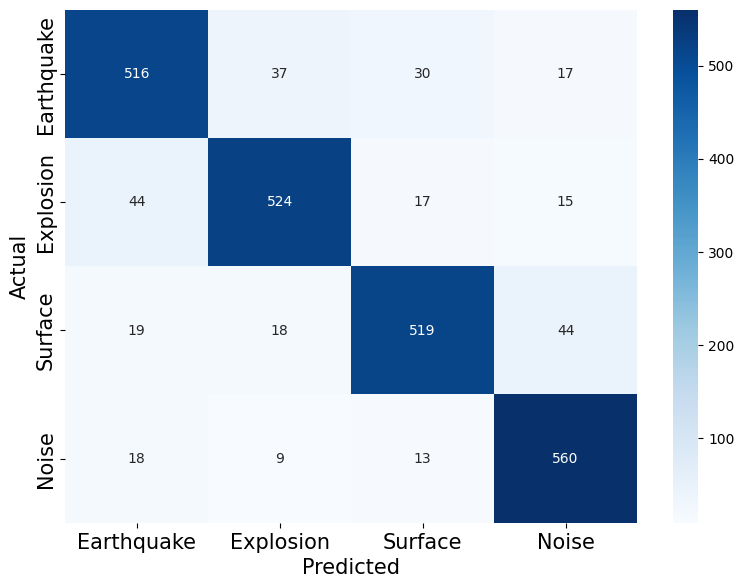

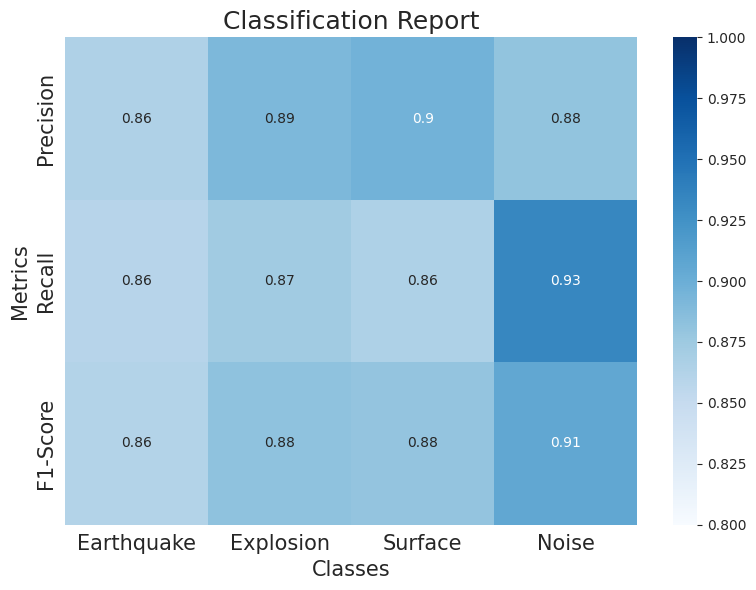

In [27]:
## plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figure_name = '../figures/confusion_matrix_hyp_tuning_phy_'+filename+'.png')


# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report(report, figure_name = '../figures/classification_report_hyp_tuning_phy_'+filename+'.png')


## Preparing the training and validation (test) sets 

In [28]:
## extracting metadata information for each kind of source along with features
## source_type_pnsn_label is more reliable label. 


# selecting all the earthquakes and their metadata information. 
a_eq = X_scaled[X_scaled['source'] == 'earthquake']

## removing the ambiguous events, these are the events that were assigned as earthquakes by pnsn but labelled as
## explosion in USGS ANSS catalog. 
a_eq = a_eq[a_eq['source'] != 'explosion']


## selecting all the explosions specifically px, (which is mainly quarry blasts)
a_px = X_scaled[X_scaled['source'] == 'explosion']
# removing the ambiguous events. 
a_px = a_px[a_px['source'] != 'earthquake']

a_su = X_scaled[X_scaled['source'] == 'surface event']
a_no = X_scaled[X_scaled['source'] == 'noise']



# Extract event IDs for each source type
eq_ids, px_ids, su_ids, no_ids = (
    np.unique(a['new_event_id'].values) for a in [a_eq, a_px, a_su, a_no]
)



## Specifying a random seed for the reproducibility. 
np.random.seed(123) 

## no. of traces per class in training set 
nos = 6000

## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), nos)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), nos)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), nos)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), nos)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_scaled.index = X_scaled['new_event_id'].values


# extracting training and testing values
X_train = X_scaled.loc[all_train_ids]
X_test = X_scaled.loc[all_test_ids]



Y_train = X_train['source'].values
Y_test = X_test['source'].values

## We can experiment by removing and adding the manual features in the cell below to see how much they contribute to performance

In [29]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.drop(['hour_of_day', 'day_of_week', 'month_of_year', 'serial_no','source','new_event_id'], axis = 1)
x_train_man = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.drop(['hour_of_day', 'day_of_week', 'month_of_year', 'serial_no','source','new_event_id'], axis = 1)
x_test_man = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



In [30]:
def compute_model_performance(x_train = x_train, x_test = x_test, holder = '_phy_', scaler_params = scaler_params):
    
    # initiating a random undersampler for randomly selecting nus traces from each class. 
    # note that these are going to be selected from training dataset which was already separated from testing 
    # dataset for the purpose of computing events wise performance. 
    
    # we have also specified a random state for reproducibility

    # number of samples per each event. 
    nus = 6000
    
    # initiating a random undersampling instance. 
    rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus,'surface event':nus,'noise':nus}, random_state = 42)
    
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    # Converting the textual labels into numerical labels
    y_num_test = label_encoder.fit_transform(Y_test)
    
    ## Creating the training dataset on which the model will be trained. 
    # randomly taking 5000 samples per class from the training dataset
    X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)
    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num_res = label_encoder.fit_transform(y_resampled)

    # No class weight since we are taking equal number of elements in each class. 
    best_model.class_weight  = None
    # fitting the model. 
    print(f'Fitting the model on {nus} randomly sampled traces per class')
    best_model.fit(X_resampled, y_num_res)
    
    
    
    
    print('Computing the trace wise performance on the global dataset')
    y_pred = best_model.predict(x_test)
    

    trace_cm_phy = confusion_matrix(y_num_test, y_pred)
    plot_confusion_matrix(trace_cm_phy, figure_name = '../figures/trace_conf_matrix'+holder+filename+'.png')

    # Calculate the classification report
    trace_report_phy = classification_report(y_num_test, y_pred, output_dict=True)
    plot_classification_report(trace_report_phy, figure_name = '../figures/trace_class_report'+holder+filename+'.png')
    
    
    
    
    print('Computing event wise performance')
    probs_all = best_model.predict_proba(x_test)

    X_test['labelled'] = y_num_test
    X_test['classified'] = y_pred
    X_test['eq_probability'] = probs_all[:,0]
    X_test['px_probability'] = probs_all[:,1]
    X_test['no_probability'] = probs_all[:,2]
    X_test['su_probability'] = probs_all[:,3]


    X_test['event_id'] = X_test['new_event_id'].str.split('_').str[0].values

    # computing the labels and event ids corresponding to each event.
    mean_labels = X_test.groupby('event_id').mean()['labelled'].values
    mean_ids = X_test.groupby('event_id').mean().index.values

    # computing the means probabilities of each class for a given event. 
    mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
    mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
    mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
    mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values
    
    # assigning a class based on the maximum among the mean probabilities of each class across the stations. 
    temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
    # computing the maximum mean probability
    temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)

    # computing the event wise confusion matrix. 
    cf_events_phy = confusion_matrix(mean_labels, temp_class)
    plot_confusion_matrix(cf_events_phy,  figure_name = '../figures/event_conf_matrix'+holder+filename+'.png')

    # computing the event wise classification report
    report_event_phy = classification_report(mean_labels, temp_class, output_dict=True)
    plot_classification_report(report_event_phy,  figure_name = '../figures/event_class_report'+holder+filename+'.png')

    
    

    
    print('Computing the performance on the balanced dataset')
    num_iter = 50
    trace_cm = []
    trace_cr = []

    for i in tqdm(range(num_iter)):
        # initiating a random undersampler
        rus = RandomUnderSampler(sampling_strategy={0:2000, 1:2000, 2:2000, 3: 2000})


        # randomly taking 2500 samples per class from the training dataset
        x_res_test, y_res_test = rus.fit_resample(x_test, y_num_test)
        
        # computing the result for the balanced classes. 
        y_res_pred = best_model.predict(x_res_test)

        trace_cm.append(confusion_matrix(y_res_test, y_res_pred))
        trace_cr.append(classification_report(y_res_test, y_res_pred, output_dict=True))


    conf_matrix = np.mean(trace_cm, axis = 0)
    # Flatten the confusion matrix to true labels and predicted labels
    y_true = []
    y_pred = []

    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[i])):
            y_true.extend([i] * int(conf_matrix[i][j]))
            y_pred.extend([j] * int(conf_matrix[i][j]))

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Earthquake', 'Explosion', 'Noise', 'Surface Event'], output_dict = True)
    
    conf_matrix = conf_matrix.astype('int') 
    plot_confusion_matrix(conf_matrix,  figure_name = '../figures/balanced_confusion_matrix'+holder+filename+'.png')
    plot_classification_report(report,  figure_name = '../figures/balanced_classification_report'+holder+filename+'.png')


    
    
    
    
    print('Saving results into disk')
    # Saving every result into disk

    # Saving trace results
    ## physical 
    
    
    
    # saving trace wise report
    with open('../results/trace_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(trace_report_phy, pickle_file)

    # saving trace wise confusion matrix
    with open('../results/trace_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(trace_cm_phy, pickle_file)



    # Saving event wise report
    with open('../results/event_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(report_event_phy, pickle_file)

    # Saving event wise confusion matrix
    with open('../results/event_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(cf_events_phy, pickle_file)


    # saving balanced trace wise report    
    with open('../results/balanced_trace_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(report, pickle_file)


    # saving balanced trace wise confusion matrix. 
    with open('../results/balanced_trace_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(conf_matrix, pickle_file)


    print('Saving trained model')
    dump(best_model, '../results/best_rf_model_all_features'+holder+filename+'.joblib')
    
    
    # saving the scaler parameters
    new_scaler_params = scaler_params
    new_scaler_params.index = new_scaler_params['Feature']

    
    print('saving the scalar params')
    new_scaler_params.to_csv('../results/scaler_params'+holder+filename+'.csv', index = False)
    

Fitting the model on 6000 randomly sampled traces per class
Computing the trace wise performance on the global dataset


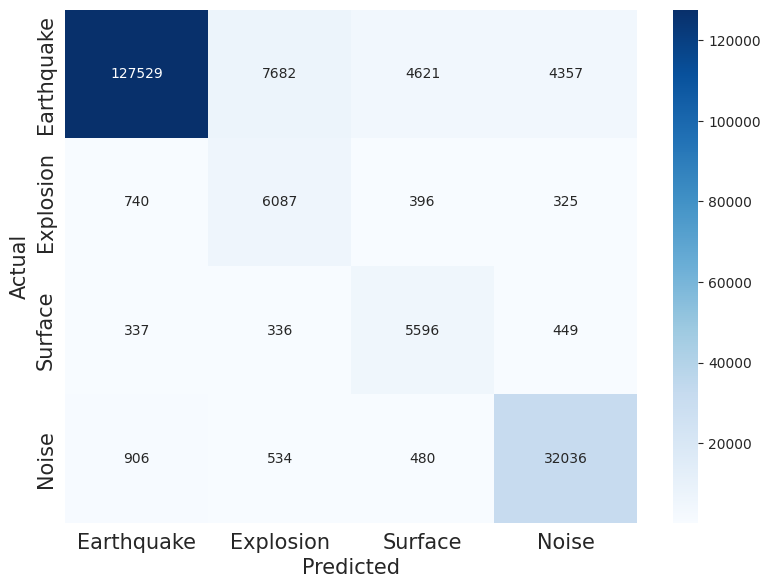

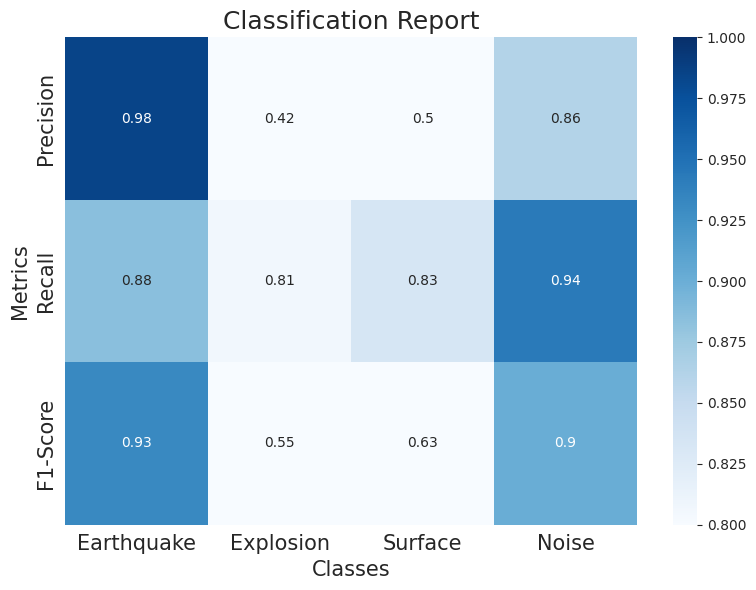

Computing event wise performance


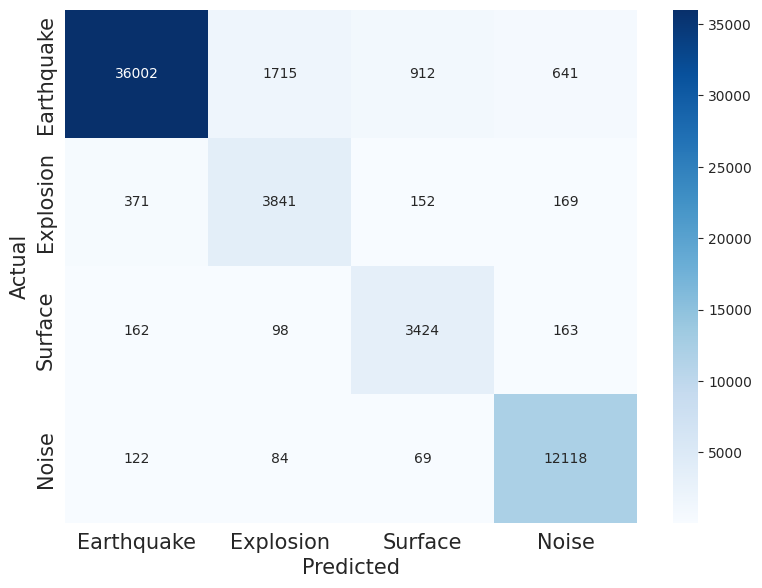

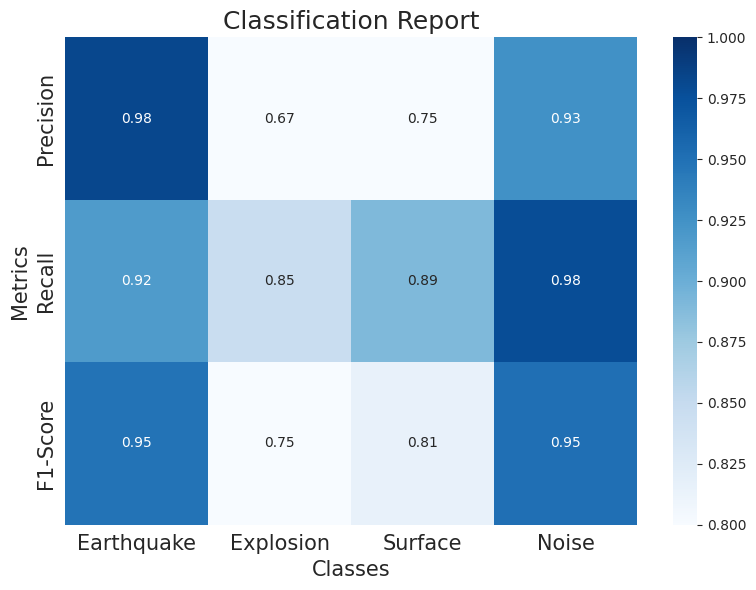

  0%|          | 0/50 [00:00<?, ?it/s]

Computing the performance on the balanced dataset


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


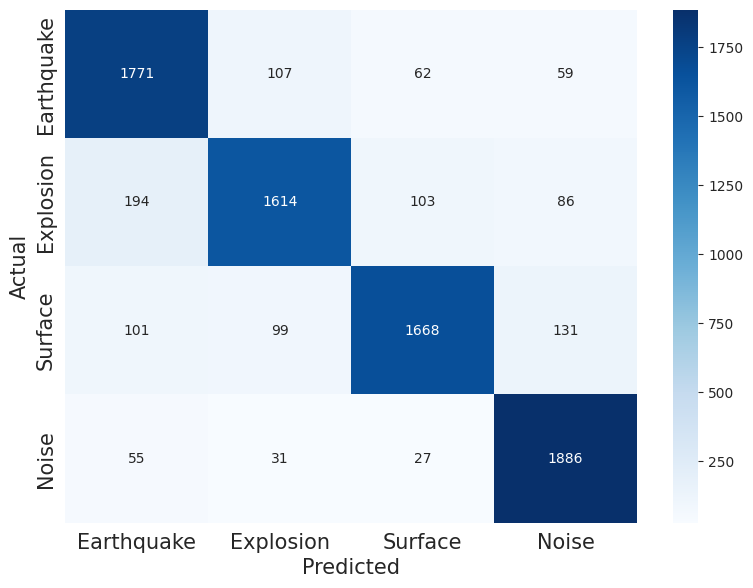

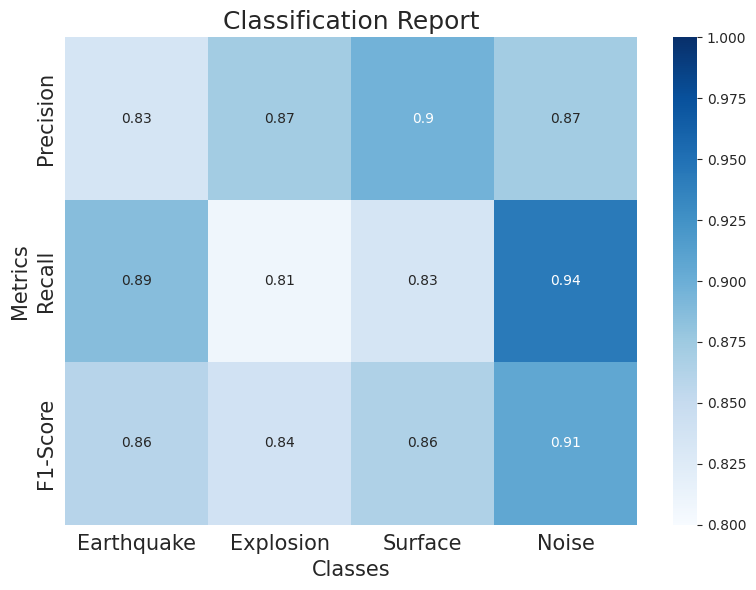

Saving results into disk
Saving trained model
saving the scalar params


In [31]:
## computing all the results just for physcial features. 
compute_model_performance(x_train = x_train, x_test = x_test, holder = '_phy_')

Fitting the model on 6000 randomly sampled traces per class
Computing the trace wise performance on the global dataset


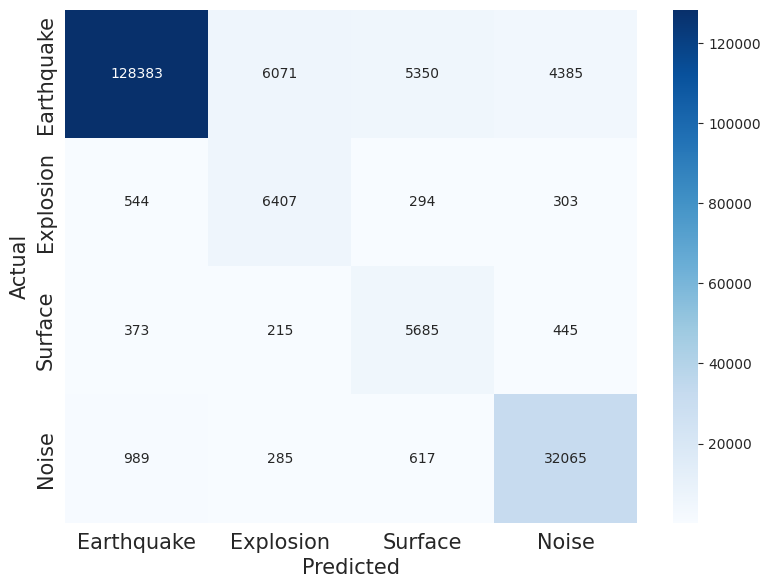

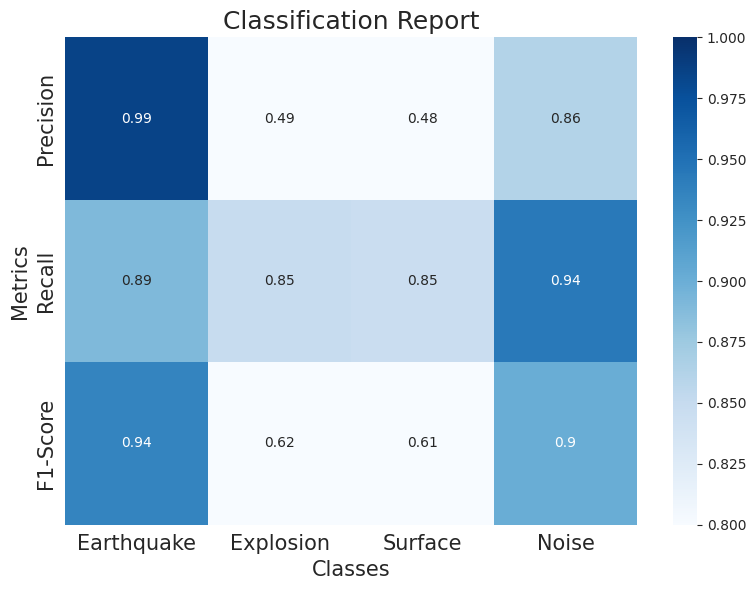

Computing event wise performance


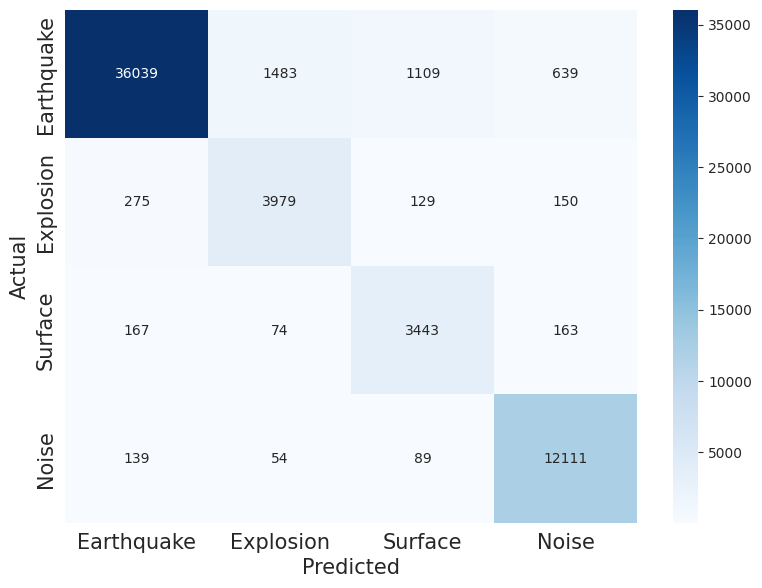

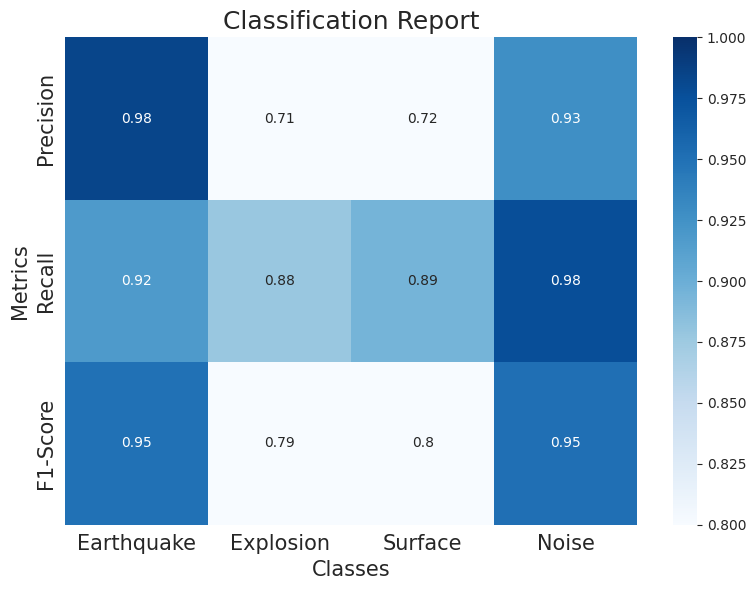

  0%|          | 0/50 [00:00<?, ?it/s]

Computing the performance on the balanced dataset


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


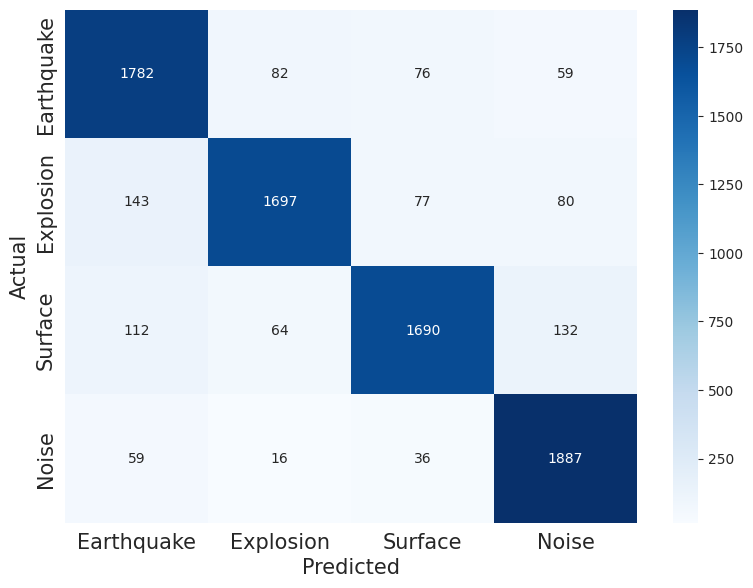

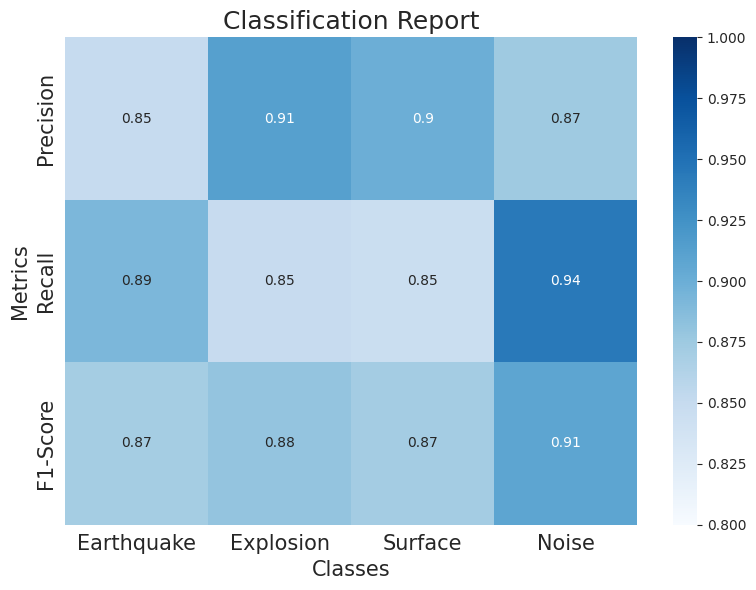

Saving results into disk
Saving trained model
saving the scalar params


In [32]:
## computing all the results just for physcial features. 
compute_model_performance(x_train = x_train_man, x_test = x_test_man, holder = '_phy_man_')

## So from the results it is clear that physical+manual features perform the best, Now in the new few cells we will compute the feature importance using the in-built way and also compute the minimum number of features required to obtain sufficiently good results

In [33]:
num_iter = 10
f_imp = []

for i in tqdm(range(num_iter)):
    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface event':3000, 'noise':3000})
    X_resampled, y_resampled = rus.fit_resample(x_train_man, Y_train)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num = label_encoder.fit_transform(y_resampled)

    # Split the data into training and testing sets
    X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)

    rf_model.fit(X_train_imp, y_train_imp)
    f_imp.append(rf_model.feature_importances_)

100%|██████████| 10/10 [00:41<00:00,  4.16s/it]


In [34]:
## averaging the importance over the iterations
final_imp = np.mean(f_imp, axis = 0)
## feature labels
features = x_train_man.columns.values

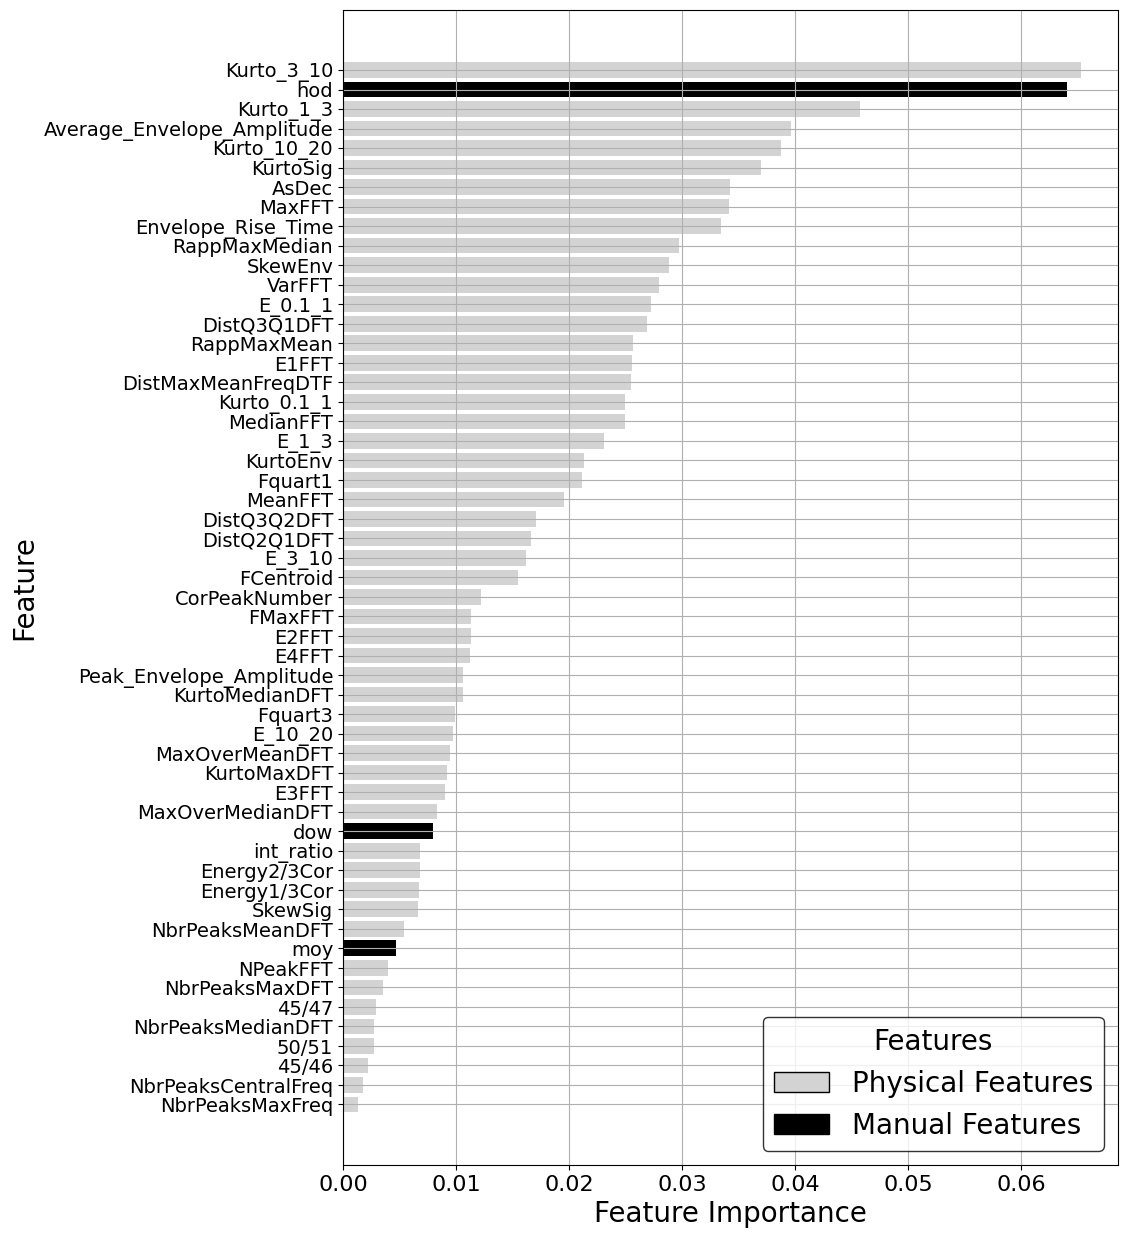

In [35]:
feature_names = features
plt.style.use('default')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels

# Sample feature importances and feature labels
feature_importances = final_imp
# Remove "0_" prefix from features that contain it
feature_labels = np.array([name[2:] if name.startswith("0_") else name for name in features])

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]

# Define a function to assign colors
def assign_colors(feature):
    if feature in ["hod", "dow", "moy"]:
        return "black"
    else:
        return "lightgray"

# Use the function to assign colors to your features
colors = [assign_colors(feature) for feature in sorted_feature_labels]

# Plotting
plt.figure(figsize=(10, 15))
bars = plt.barh(sorted_feature_labels, sorted_feature_importances, color=colors)

# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='lightgray', ec='black'), plt.Rectangle((0,0),1,1, color='black', ec='black')]
legend_labels = ['Physical Features', 'Manual Features']

plt.legend(legend_handles, legend_labels, title='Features', title_fontsize=20, frameon=True, fontsize = 20, facecolor='white', edgecolor='black')

plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Set y-axis tick label size
plt.yticks(fontsize=14)
plt.grid('on')

# Save the figure in high-resolution
plt.savefig('../figures/feature_importances.png', dpi=300, bbox_inches='tight')

plt.show()

In [36]:
print('Sorted Feature Importances')
for i in range(len(sorted_feature_labels)):
    print(f'{sorted_feature_labels[i]}: {sorted_feature_importances[i]}')

Sorted Feature Importances
Kurto_3_10: 0.06531192049925345
hod: 0.06409117185028597
Kurto_1_3: 0.045796552500784085
Average_Envelope_Amplitude: 0.03964599192985076
Kurto_10_20: 0.03879793971066744
KurtoSig: 0.03696289294067505
AsDec: 0.034290921740601416
MaxFFT: 0.034173534409484646
Envelope_Rise_Time: 0.033447955525706626
RappMaxMedian: 0.02977521856889289
SkewEnv: 0.028829163732754202
VarFFT: 0.027998991628522724
E_0.1_1: 0.027248529844899467
DistQ3Q1DFT: 0.0268958594096342
RappMaxMean: 0.02569263079406765
E1FFT: 0.02559848362782477
DistMaxMeanFreqDTF: 0.025518586215098393
Kurto_0.1_1: 0.02495077397027321
MedianFFT: 0.02493052491675925
E_1_3: 0.02311177035946239
KurtoEnv: 0.021298862395221666
Fquart1: 0.021121139357327755
MeanFFT: 0.019578094499388334
DistQ3Q2DFT: 0.017057012210471338
DistQ2Q1DFT: 0.016601095044599272
E_3_10: 0.016245519113958874
FCentroid: 0.015473034679034905
CorPeakNumber: 0.01218661209409514
FMaxFFT: 0.01135664646644426
E2FFT: 0.011301673599880551
E4FFT: 0.011260

## Visualizing most important physical features

/home/ak287/PNW_Seismic_Event_Classification/notebooks/../src/utils.py:238: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df >= df.quantile(lower_quantile)) &
/home/ak287/PNW_Seismic_Event_Classification/notebooks/../src/utils.py:239: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df <= df.quantile(upper_quantile))


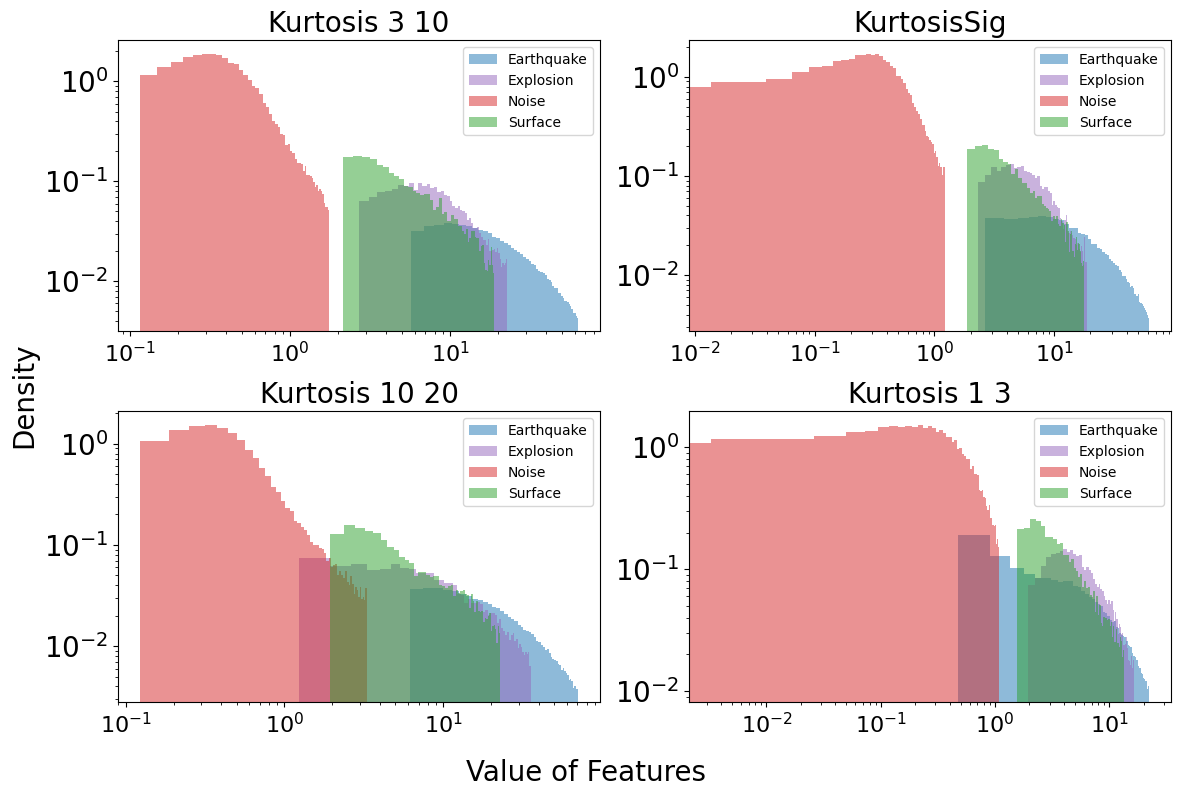

In [37]:
no_df = features_noise_physical
eq_df = features_earthquake_physical
su_df = features_exotic_physical[features_exotic_physical['source'] == 'surface event']
exp_df = features_explosion_physical

filtered_no = interquartile(no_df)
filtered_su = interquartile(su_df)
filtered_eq = interquartile(eq_df)
filtered_exp = interquartile(exp_df)


# Define a function for histogram plotting
def plot_histogram(ax, feature_data, label, color, num_bins, title):
    ax.hist(x=feature_data, bins=num_bins, density=True, color=color, alpha=0.5, label=label)
    ax.legend()
    # Process the string
    output_string = title.replace("Kurto", "Kurtosis").replace("_", " ")
    #output_string = output_string[:9] + "(" + output_string[10:] + " Hz)"
    #output_string = output_string.replace(" ", "-")
    ax.set_title(output_string, fontsize=20)

# Define common parameters
num_bins = 50
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[12, 8])

# Define features and labels
features = {
    'Kurto_3_10': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'KurtoSig': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'Kurto_10_20': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'Kurto_1_3': [filtered_eq, filtered_exp, filtered_no, filtered_su]
}
labels = ['Earthquake', 'Explosion', 'Noise', 'Surface']
colors = ['#1f77b4', '#9467bd', '#d62728',  '#2ca02c']

# Iterate over features and plot histograms
for idx, (feature, (filtered_eq, filtered_exp, filtered_no, filtered_su)) in enumerate(features.items()):
    row = idx // 2
    col = idx % 2
    plot_histogram(ax[row, col], filtered_eq[feature].values, labels[0], colors[0], num_bins, feature)
    plot_histogram(ax[row, col], filtered_exp[feature].values, labels[1], colors[1], num_bins, feature)
    plot_histogram(ax[row, col], filtered_no[feature].values, labels[2], colors[2], num_bins, feature)
    plot_histogram(ax[row, col], filtered_su[feature].values, labels[3], colors[3], num_bins, feature)
    #ax[row, col].set_xlim(filtered_eq[feature].quantile(0.001), filtered_eq[feature].quantile(0.9))
    ax[row,col].set_xscale('log')
    ax[row,col].set_yscale('log')
    
    
fig.supylabel('Density', fontsize=20)
fig.supxlabel('Value of Features', fontsize=20)
fig.tight_layout()

# Save the figure in high-resolution
plt.savefig('../figures/feature_histograms.png', dpi=300, bbox_inches='tight')

plt.show()


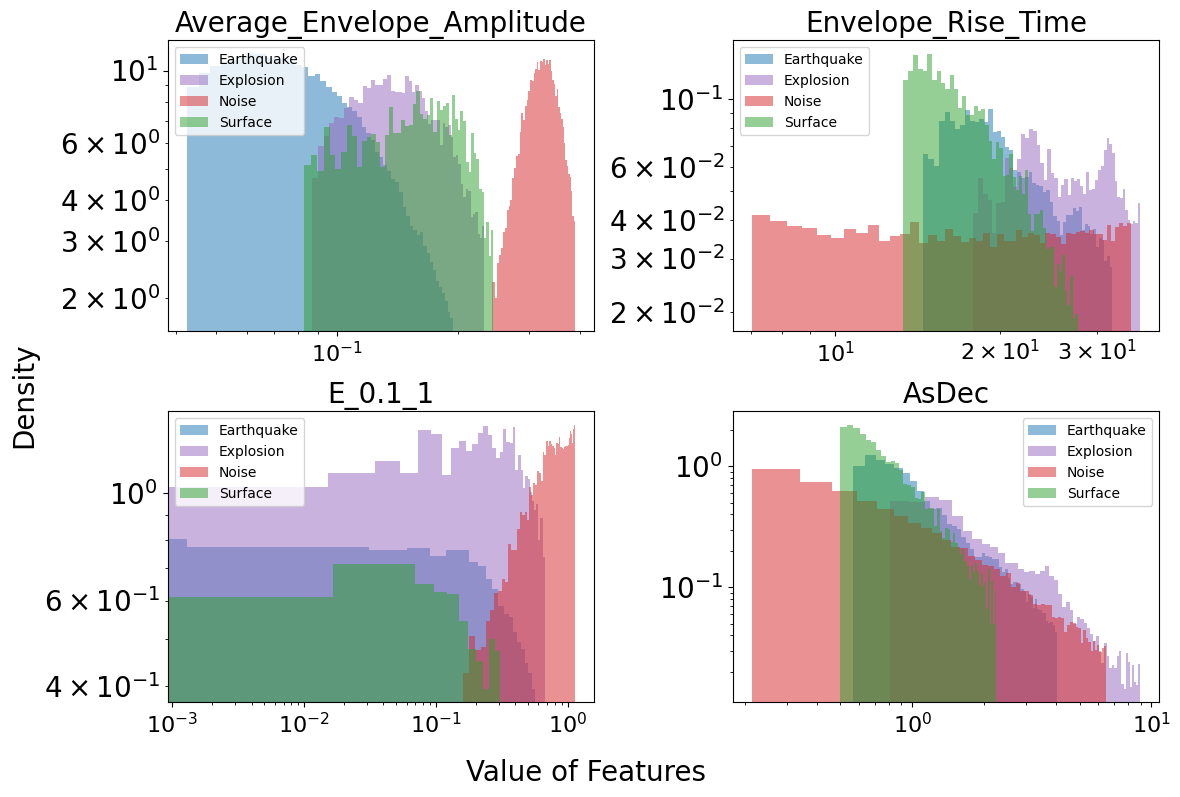

In [38]:
no_df = features_noise_physical
eq_df = features_earthquake_physical
su_df = features_exotic_physical[features_exotic_physical['source'] == 'surface event']
exp_df = features_explosion_physical

filtered_no = interquartile(no_df)
filtered_su = interquartile(su_df)
filtered_eq = interquartile(eq_df)
filtered_exp = interquartile(exp_df)


# Define a function for histogram plotting
def plot_histogram(ax, feature_data, label, color, num_bins, title):
    ax.hist(x=feature_data, bins=num_bins, density=True, color=color, alpha=0.5, label=label)
    ax.legend()
    ax.set_title(title, fontsize=20)

# Define common parameters
num_bins = 50
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[12, 8])

# Define features and labels
features = {
    'Average_Envelope_Amplitude': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'Envelope_Rise_Time': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'E_0.1_1': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'AsDec': [filtered_eq, filtered_exp, filtered_no, filtered_su]
}
labels = ['Earthquake', 'Explosion', 'Noise', 'Surface']
colors = ['#1f77b4', '#9467bd', '#d62728',  '#2ca02c']

# Iterate over features and plot histograms
for idx, (feature, (filtered_eq, filtered_exp, filtered_no, filtered_su)) in enumerate(features.items()):
    row = idx // 2
    col = idx % 2
    plot_histogram(ax[row, col], filtered_eq[feature].values, labels[0], colors[0], num_bins, feature)
    plot_histogram(ax[row, col], filtered_exp[feature].values, labels[1], colors[1], num_bins, feature)
    plot_histogram(ax[row, col], filtered_no[feature].values, labels[2], colors[2], num_bins, feature)
    plot_histogram(ax[row, col], filtered_su[feature].values, labels[3], colors[3], num_bins, feature)
    #ax[row, col].set_xlim(filtered_eq[feature].quantile(0.001), filtered_eq[feature].quantile(0.9))
    ax[row,col].set_xscale('log')
    ax[row,col].set_yscale('log')
    
    
fig.supylabel('Density', fontsize=20)
fig.supxlabel('Value of Features', fontsize=20)
fig.tight_layout()

# Save the figure in high-resolution
plt.savefig('../figures/feature_histograms.png', dpi=300, bbox_inches='tight')

plt.show()


## Feature Selection

In [39]:
## based on the X_train and X_test computed previously. They should contain 2400 and 600 events per class respectively. 
results_dict = []
selected_features = []
model = RandomForestClassifier()
model_fitting_times = []
for i in tqdm(range(1, len(sorted_feature_labels), 2)):
    
    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface event':3000, 'noise':3000})
    X_resampled, y_resampled = rus.fit_resample(x_train_man, Y_train)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num = label_encoder.fit_transform(y_resampled)


    # Split the data into training and testing sets
    X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)    
    
    
    
    selected_features = sorted_feature_labels[0:i]
    X_temp_train = X_train_imp[selected_features].copy()
    X_temp_test = X_test_imp[selected_features].copy()
    
    start_time = time.time()
    model.fit(X_temp_train, y_train_imp)
    model_fitting_times.append(time.time() - start_time)
    y_pred_imp = model.predict(X_temp_test)
    results_dict.append(classification_report(y_test_imp, y_pred_imp, output_dict=True))


100%|██████████| 27/27 [01:24<00:00,  3.14s/it]


In [40]:
# Define the labels for surface events, explosions, and earthquakes
labels = ['3', '1', '0']

# Define a function to extract metrics based on the label and metric type
def extract_metric(results_dict, label, metric):
    return [results_dict[i][label][metric] for i in range(len(results_dict))]

# Extract accuracy, f1, precision, and recall for individual and group assessment
acc_features = [results_dict[i]['accuracy'] for i in range(len(results_dict))]
f1_features, prec_features, rec_features = (
    extract_metric(results_dict, 'macro avg', metric)
    for metric in ['f1-score', 'precision', 'recall']
)

# Extract f1, precision, and recall for surface events, explosions, and earthquakes
f1_su, prec_su, rec_su = (extract_metric(results_dict, '3', metric) for metric in ['f1-score', 'precision', 'recall'])
f1_exp, prec_exp, rec_exp = (extract_metric(results_dict, '1', metric) for metric in ['f1-score', 'precision', 'recall'])
f1_eq, prec_eq, rec_eq = (extract_metric(results_dict, '0', metric) for metric in ['f1-score', 'precision', 'recall'])


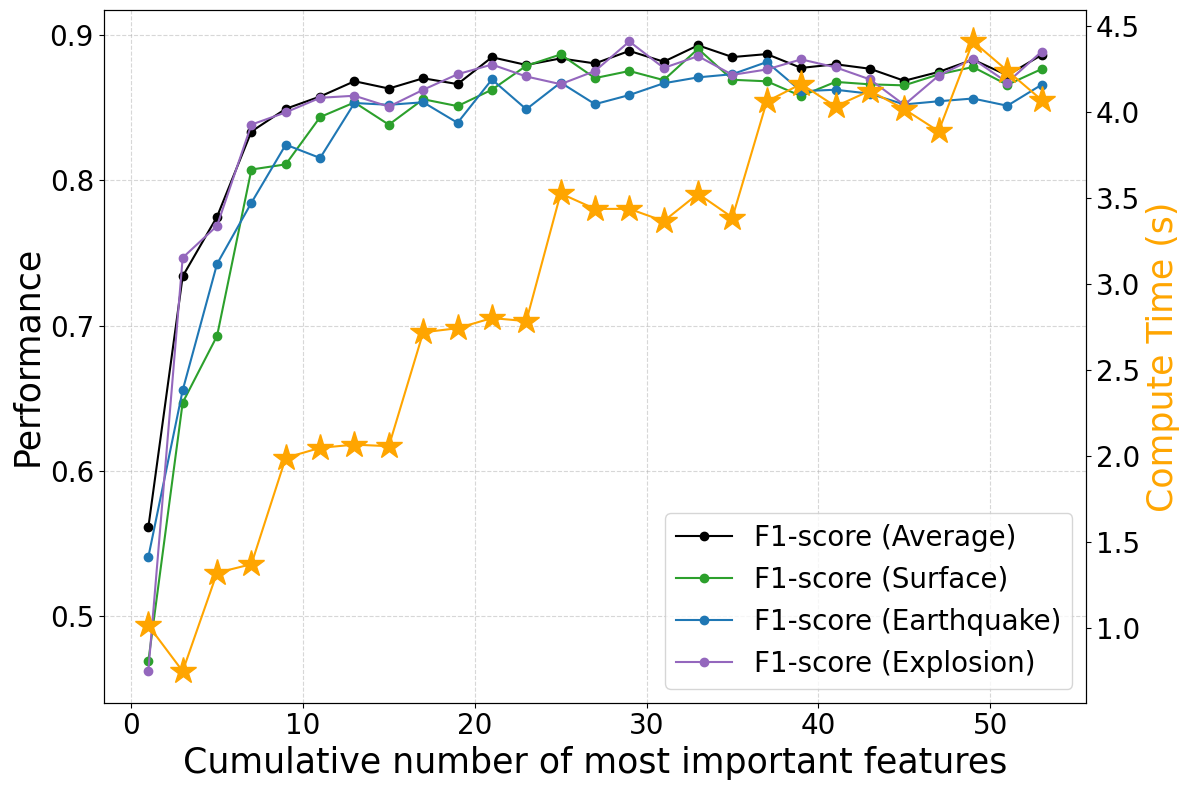

In [41]:
# Create a figure and axis for the main plot
fig, ax = plt.subplots(figsize=[12, 8])



cb_palette = ['#1f77b4','#9467bd',   '#d62728',  '#2ca02c',  ]


# Main plot
ax.plot(np.arange(1, len(sorted_feature_labels), 2), f1_features, marker='o', label='F1-score (Average)', color='k', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 2), f1_su, marker='o', label='F1-score (Surface)', color= '#2ca02c', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 2), f1_eq, marker='o', label='F1-score (Earthquake)', color='#1f77b4', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 2), f1_exp, marker='o', label='F1-score (Explosion)', color= '#9467bd', linestyle='-')


ax1 = ax.twinx()
ax1.plot(np.arange(1, len(sorted_feature_labels), 2), model_fitting_times, marker='*', markersize = 20,  color= 'orange', linestyle='-', label = 'compute time(s)')
ax1.set_ylabel('Compute Time (s)', fontsize = 25, c = 'orange')
#ax.plot(np.arange(1, len(sorted_feature_labels), 10), f1_features, marker='o', label='F1-score', color=colors(0), linestyle='-')


#ax.plot(np.arange(len(f1_features)), acc_features, marker='s', label='Accuracy', color=colors(1), linestyle='--')
#ax.plot(np.arange(len(f1_features)), prec_features, marker='^', label='Precision', color=colors(2), linestyle='-.')
#ax.plot(np.arange(len(f1_features)), rec_features, marker='d', label='Recall', color=colors(3), linestyle=':')
ax.legend(fontsize= 20, loc='lower right')
ax.set_xlabel('Cumulative number of most important features', fontsize=25)
ax.set_ylabel('Performance', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, linestyle='--', alpha=0.5)
#ax.set_title('Performance Metrics vs. Number of Features', fontsize=25)



plt.tight_layout()
plt.show()


## Testing with reduced number of features

Fitting the model on 6000 randomly sampled traces per class
Computing the trace wise performance on the global dataset


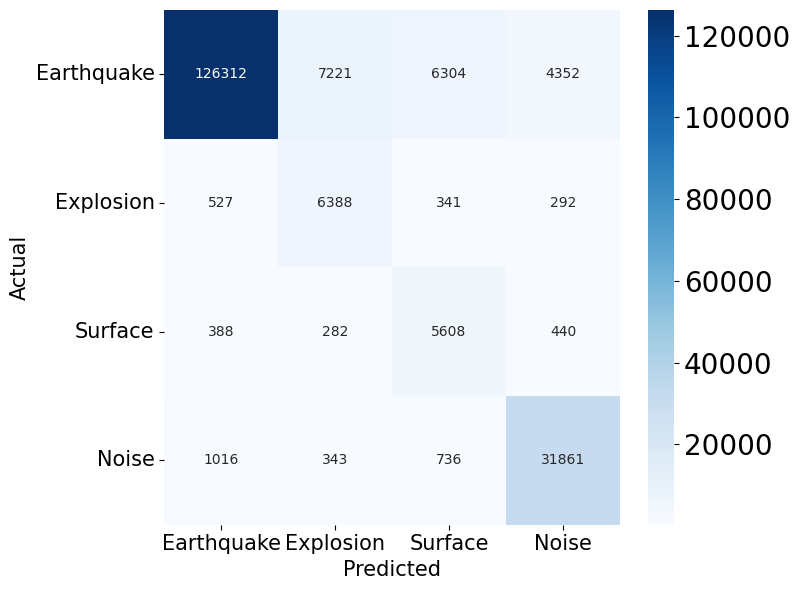

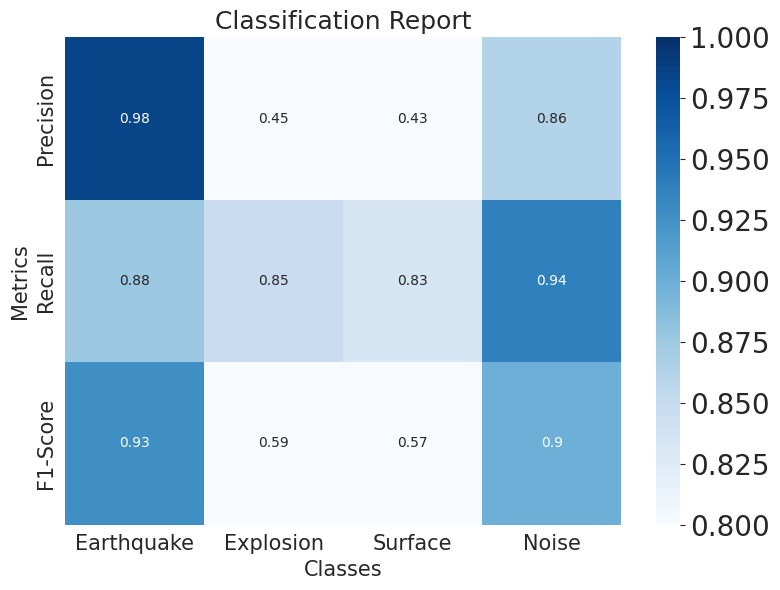

Computing event wise performance


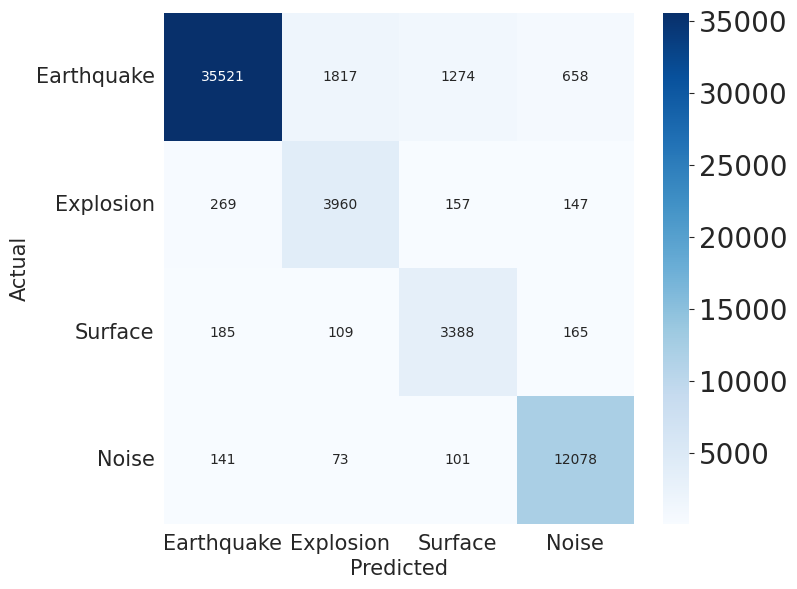

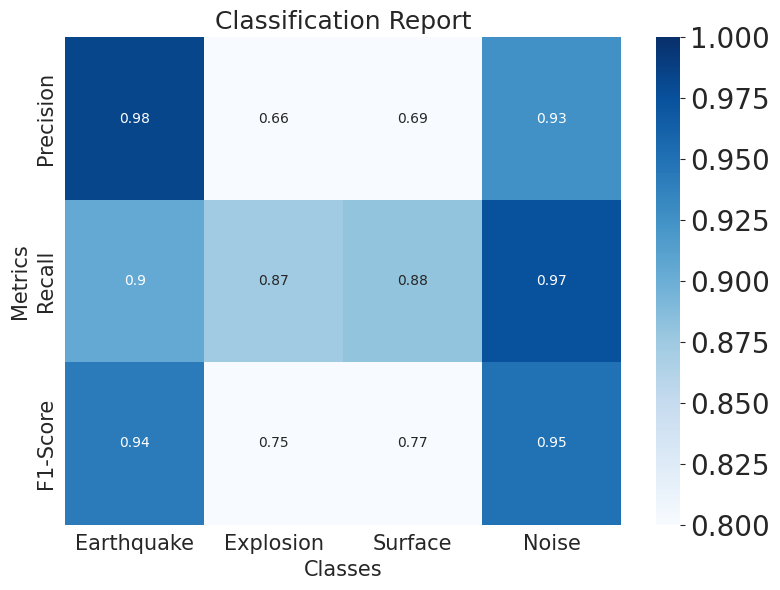

  0%|          | 0/50 [00:00<?, ?it/s]

Computing the performance on the balanced dataset


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


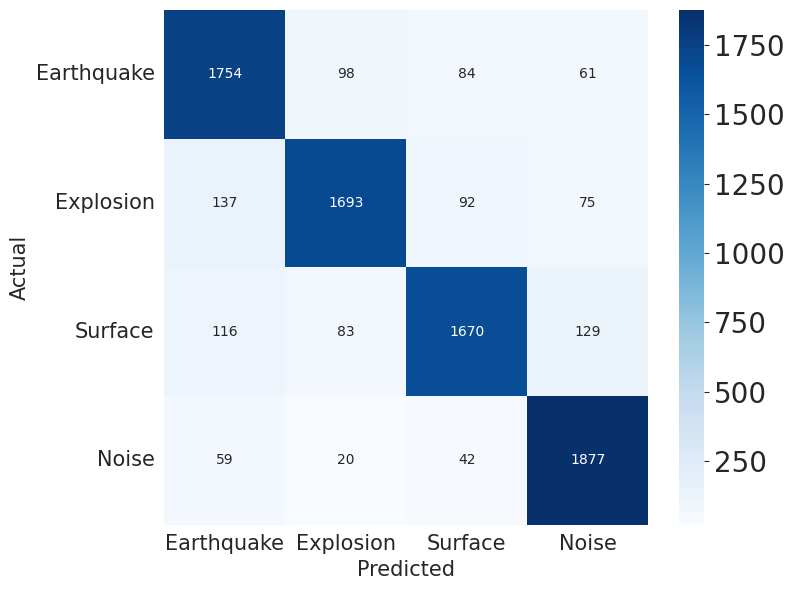

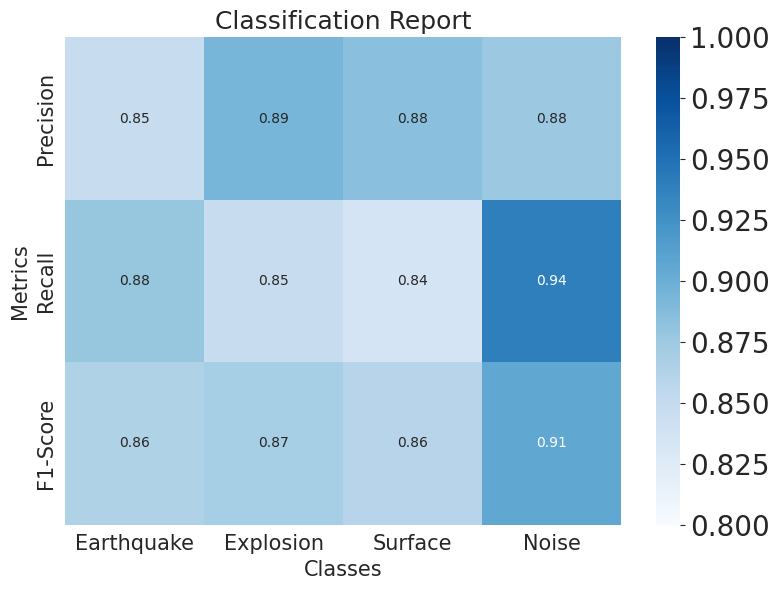

Saving results into disk
Saving trained model
saving the scalar params


In [42]:
## computing all the results just for physcial features. 
compute_model_performance(x_train = x_train_man[sorted_feature_labels[0:20]], x_test = x_test_man[sorted_feature_labels[0:20]], holder = '_phy_man_top_20_')









